In [1]:
from utils.arguments import parse_args
from utils.dataloader import DatasetQuickdraw
import utils.misc as misc
from algorithms import create_model
import torch.optim as optim
import torch
import os

import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
misc.seed_all(0)
transform = None
dataset_train = DatasetQuickdraw('quickdraw_png', transform, mode="train")
dataset_test = DatasetQuickdraw('quickdraw_png', transform, mode="test")

Data loading:   4%|▍         | 1/25 [00:00<00:03,  6.51it/s]

Data: Loaded 1750000 samples


Data loading: 100%|██████████| 25/25 [00:01<00:00, 14.83it/s]

Data: Loaded 62500 samples


In [3]:
data = dataset_train.data
labels = dataset_train.labels

In [4]:
data = np.array(data, dtype='float32')/255.0
labels = np.array(labels)

In [41]:
data.shape[0]

1750000

In [5]:
import random 
combine = list(zip(data, labels))
random.shuffle(combine)

data[:], labels[:] = zip(*combine)
data = data.reshape(data.shape[0],-1)

In [35]:
data_training = []
data_test = []
label_training = []
label_test = []
training = [0 for i in range(25)]
test = [0 for i in range(25)]
for i in range(data.shape[0]):
    tmp = labels[i]
    if training[int(tmp)] < 100:
        data_training.append(data[i])
        label_training.append(tmp)
        training[int(tmp)]+=1
    elif test[int(tmp)] <20:
        data_test.append(data[i])
        label_test.append(tmp)
        test[int(tmp)]+=1
    elif min(training)==100 and min(test)==20:
        break

In [36]:
data_training = np.array(data_training)
label_training = np.array(label_training)
data_training.shape

(2500, 784)

In [37]:
combined = list(zip(data_training, label_training))
random.shuffle(combined)

data_training[:], label_training[:] = zip(*combined)
data_training = data_training.reshape(data_training.shape[0],-1)

In [40]:
from sklearn import svm 
svm_classifier = svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(data_training, label_training)
y_pred = svm_classifier.predict(data_training)
svm_classifier.score(data_training, label_training)

0.5256

In [41]:
data_test = np.array(data_test)
label_test = np.array(label_test)
data_test = data_test.reshape(data_test.shape[0],-1)
svm_classifier.score(data_test, label_test)

0.2

In [42]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_list = [0.01, 0.1, 1.0, 10.0, 100.0]
train = {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
test =  {'linear':[], 'rbf':[], 'poly':[], 'sigmoid':[]}
for C in C_list:
    for kernel in kernels:
        svm_classifier = svm.SVC(kernel=kernel,C=C)
        svm_classifier.fit(data_training, label_training)
        y_pred = svm_classifier.predict(data_training)
        train_acc = svm_classifier.score(data_training, label_training)
        train[kernel].append(train_acc)
        
        data_test = np.array(data_test)
        label_test = np.array(label_test)
        data_test = data_test.reshape(data_test.shape[0],-1)
        test_acc = svm_classifier.score(data_test, label_test)
        test[kernel].append(test_acc)

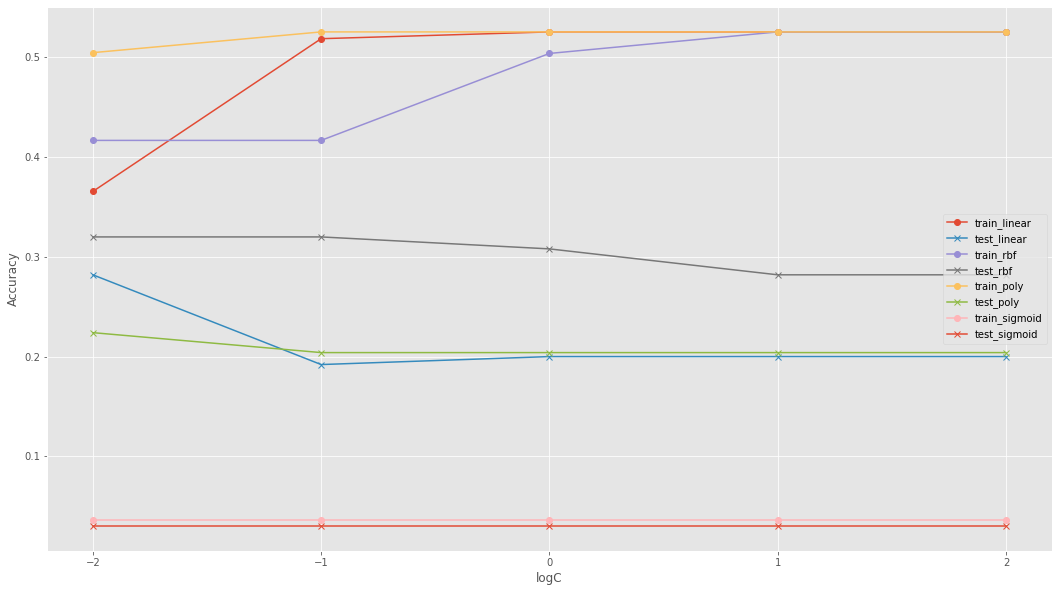

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
%matplotlib inline
def show():
    legend_list = []
    fig = plt.figure(figsize=(18,10))
    for kernel in kernels:
        plt.plot([-2, -1, 0, 1, 2], train[kernel], 'o-')
        plt.plot([-2, -1, 0, 1, 2], test[kernel], 'x-')
        
        legend_list.append('train_'+kernel)
        legend_list.append('test_'+kernel)
    
    plt.xticks([-2, -1, 0, 1, 2])
    plt.xlabel('logC')
    plt.ylabel('Accuracy')
    plt.legend(legend_list)
    plt.savefig('svm.png')
    plt.show()
show()

In [69]:
train

{'linear': [0.3656, 0.5188, 0.5256, 0.5256, 0.5256],
 'rbf': [0.4168, 0.4168, 0.504, 0.5256, 0.5256],
 'poly': [0.5048, 0.5256, 0.5256, 0.5256, 0.5256],
 'sigmoid': [0.0364, 0.0364, 0.0364, 0.0364, 0.0364]}

In [70]:
test

{'linear': [0.282, 0.192, 0.2, 0.2, 0.2],
 'rbf': [0.32, 0.32, 0.308, 0.282, 0.282],
 'poly': [0.224, 0.204, 0.204, 0.204, 0.204],
 'sigmoid': [0.03, 0.03, 0.03, 0.03, 0.03]}

In [79]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.tight_layout()

In [76]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(data_training, label_training)
y_pred = svm_classifier.predict(data_training)
svm_classifier.score(data_training, label_training)

0.5256

In [77]:
cnf_matrix = confusion_matrix(label_training, y_pred)
classes = [i for i in range(25)]
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Confusion matrix, without normalization
[[58  2  1  3  0  5  2  1  0  1  3  2  1  2  2  2  1  2  3  2  2  2  1  1
   1]
 [ 1 44  1  4  1  3  2  1  1  1  1  3  5  1  3  0  4  4  2  2  4  0  1  5
   6]
 [ 5  0 52  3  2  2  1  0  0  5  2  2  1  0  1  3  3  1  3  3  0  2  4  3
   2]
 [ 4  1  1 54  2  2  1  1  0  1  2  2  1  1  3  2  1  3  4  3  2  4  3  1
   1]
 [ 3  0  2  1 59  5  1  2  2  1  3  3  1  2  0  3  0  2  1  0  1  3  3  1
   1]
 [ 2  0  2  2  5 56  2  1  1  1  1  2  4  2  1  2  2  1  2  3  2  1  1  2
   2]
 [ 5  0  3  0  3  3 44  0  1  2  4  1  4  3  0  2  6  4  2  2  3  3  2  1
   2]
 [ 1  1  4  2  4  1  2 47  2  3  1  3  1  3  3  0  3  3  4  3  0  4  2  1
   2]
 [ 3  1  2  0  2  5  1  4 52  1  0  2  0  1  1  5  1  1  3  1  2  4  0  5
   3]
 [ 1  1  4  1  4  3  1  4  1 37  1  1  2  4  1  2  4  2  2  5  3  6  1  6
   3]
 [ 0  1  0  2  1  2  1  3  1  1 54  3  2  1  5  3  0  1  5  1  3  4  0  3
   3]
 [ 0  2  4  3  2  0  0  3  1  2  0 60  1  3  3  3  2  4  1  1  1  2  0  0
   2]


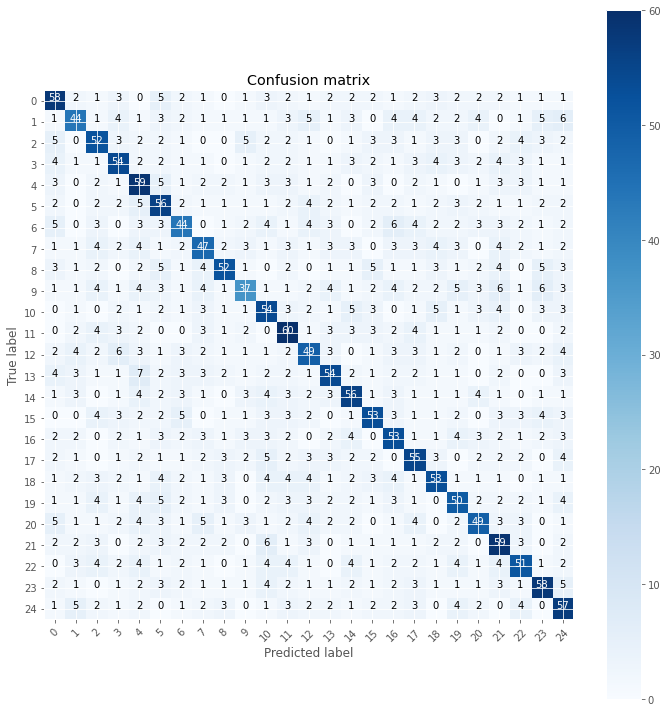

In [80]:
plot_confusion_matrix(cnf_matrix, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues)